# Recommender System for Information Retrieval

## Author: Davide Roznowicz

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Introduction to the scope of the project

Build a Recommender System by following the project requirements:
- Find a user-item dataset detailing which items the user has liked
- Build a Weighted MF to find the user and item embedding
- Allow to choose a user we should recommend items to
- Return a ranking of documents

The focus will be on collaborative filtering: it means that our recommendations to the user will derive from similarities of interest and behaviour among users themselves and items, by valuing the information within user and item embeddings.

We are interested in building item and user embeddings in order to be capable to make predictions. Not only that: it also allows us to compress the information contained within the user-item interaction matrix.

-------------------------------------------------------------
-------------------------------------------------------------

In [35]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from math import sqrt
from scipy.sparse import bsr_array

# import custom packages
from data_preprocessing import *

## 1. Dataset

### 1.1 Chosen Dataset

The dataset we decided to use contains social networking and music artist listening information and has been extracted from [this website](https://www.last.fm/). Further information is available in the [readme.txt](data/readme.txt).

The main reasons for choosing this dataset are the following:
- not too big to be run on a notebook (short training times)
- very suitable to the requirements of the project: in fact, the act of a user listening/following a certain artist corresponds to a $1$ in the interaction matrix (the user shows appreciation for the artist); otherwise $0$

In this context, the "artists" correspond to the "items". Our purpose is to be able to recommend artists to users, according to their similarity of interests (e.g. they listen to similar artists) compared to other users.

### 1.2 Type of dataset

The dataset is somehow structured like the image below:

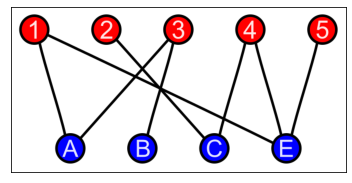

In [4]:
img = mpimg.imread('bipartite_graph_example.png')
imgplot = plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

The image is not meant to identify our real dataset in any way: its only purpose is to send the message that we should be dealing with a structure that reminds the one of a bipartite graph, where two separate subsets of nodes interact with each other but no nodes within one subset interact (for example red nodes have no direct edge; the same applies to blue nodes).

In our case, red nodes can be regarded as users, while blue nodes can be considered as artists. An edge between a user and an artist might represent that the user liked the artist: that relationship will be encoded within the matrix factorization in such a way that users which show similar interests to others have a more similar embedding. Therefore, our goal becomes to forecast the edges which are more likely to appear next, by recommending the related artists to the user.

### 1.3. Data preprocessing

In [42]:
data_dir = "data/"

# store datasets in dataframes
df_user_artists = pd.read_table(f"{data_dir}/user_artists.dat")
df_artists = pd.read_table(f"{data_dir}/artists.dat")

In [43]:
df_user_artists.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [44]:
df_artists.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


For the pure purpose of the project, we prefer to downsize the dataset. We saw the computation of the WALS algorithm tends to be too slow in case someone does not have any GPUs. Therefore, we set a threshold and decide to eliminate all the IDs of all the artists who have less than "threshold" followers (i.e. users listening to them).

In [45]:
# set a threshold
threshold = 100

# how many artists are we going to drop from the dataset?
res = df_user_artists.groupby(['artistID']).count()
print((res<threshold).sum()[0])

17506


In [46]:
res

,userID,weight
artistID,,
1,3,3
2,12,12
3,3,3
4,2,2
5,2,2
...,...,...
18741,1,1
18742,1,1
18743,1,1


In [47]:
# list of artists to drop
artist_ids = res.loc[res["userID"] < threshold]
artist_ID_to_drop = list(artist_ids.index)

# let's drop them
df_user_artists = df_user_artists[~df_user_artists['artistID'].isin(artist_ID_to_drop)]
df_artists = df_artists[~df_artists['id'].isin(artist_ID_to_drop)]


In [48]:
df_user_artists

,userID,artistID,weight
0,2,51,13883
4,2,55,8983
5,2,56,6152
8,2,59,4337
14,2,65,3579
...,...,...,...
92709,2097,533,145
92710,2097,614,125
92712,2097,709,601
92714,2097,982,225


In [49]:
df_artists

,id,name,url,pictureURL
6,7,Marilyn Manson,http://www.last.fm/music/Marilyn+Manson,http://userserve-ak.last.fm/serve/252/2558217.jpg
45,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
49,55,Kylie Minogue,http://www.last.fm/music/Kylie+Minogue,http://userserve-ak.last.fm/serve/252/12740835...
50,56,Daft Punk,http://www.last.fm/music/Daft+Punk,http://userserve-ak.last.fm/serve/252/10923145...
53,59,New Order,http://www.last.fm/music/New+Order,http://userserve-ak.last.fm/serve/252/6650979.jpg
...,...,...,...,...
1391,1400,MGMT,http://www.last.fm/music/MGMT,http://userserve-ak.last.fm/serve/252/18032577...
1403,1412,Led Zeppelin,http://www.last.fm/music/Led+Zeppelin,http://userserve-ak.last.fm/serve/252/279035.jpg
1504,1513,Ramones,http://www.last.fm/music/Ramones,http://userserve-ak.last.fm/serve/252/3531055.jpg
1663,1672,Avenged Sevenfold,http://www.last.fm/music/Avenged+Sevenfold,http://userserve-ak.last.fm/serve/252/4611014.jpg


In [50]:
# drop columns which are not relevant for the project
# fix userID for better indexing when building the matrix afterwards
# fix artistID for better indexing when building the matrix afterwards
df_artists, df_user_artists = main_preprocess(df_artists, df_user_artists)

In [51]:
a=np.array(df_user_artists['artistID'].unique())
b=np.array(df_artists['id'].unique())


# we want to see which artists are not listened by any user
np.setdiff1d(b, a)

array([], dtype=int64)

**It turns out that there is always at least one user listening to any artist in the dataframe.** In general, should a new artist be added, we would need to find a way to recommend that artist to the users, according to the users characteristics (for example genre of the music or similarity to other liked artist by a specified user), or according to alternative information (search history of the user on other wesites, cookies, IP address ...). In the current dataset, we would have too limited information to make such a recommendation given the absence of alternative features about the new artist.

In [52]:
# build the user-item interaction matrix C

row=np.array(df_user_artists['userID'])
col=np.array(df_user_artists['artistID'])
data = np.ones((col.shape[0],1)).reshape(-1)


num_unique_rows = df_user_artists['userID'].unique().shape[0]
num_unique_cols = df_user_artists['artistID'].unique().shape[0]
C=bsr_array((data, (row, col)), shape=(num_unique_rows, num_unique_cols)).toarray()

In [18]:
C.shape

(1813, 126)

## 2. Weighted Matrix Factorization via WALS

### 2.1. Problem statement

Given the matrix $C$, describing user-item interaction, we want to compute a matrix factorization such that:

$C \approx U \cdot V^T \quad$ via minimization of $L(p_i, q_j, c_{ij})=\sum_{j=0}^{n-1} w_{ij}(c_{ij}-u_{i}^T v_j)^2 + \lambda \sum_{z=0}^{k-1} u_{iz}^2$

where:
- $C \quad (m \times n)$ is the interaction matrix  (1 if the user liked the document)
- $U \quad (m \times k)$ is the user embedding      (each row represents a user)
- $V \quad (n \times k)$ is the item embedding      (each row represents an item)

### 2.2. Computation via WALS algorithm

We perform the WALS algorithm, according to the loss function above. A regularization term is present as well.

In [32]:
class WALS:
    def __init__(self, C, k=3, a=40, lambd=10):
        self.C = C
        self.k = k # latent dimension for the embeddings
        self.a = a
        self.lambd = lambd
        self.m, self.n = self.C.shape
        self.U = np.random.rand(self.m, self.k)
        self.V = np.random.rand(self.n, self.k)
        self.W = 1 + self.a*self.C  # Confidence of preference.
        self.loss = []

    def train(self, n_step=10):
        l2_reg = self.lambd * np.identity(self.k)
        for step in range(n_step):
            # Each step contains two alternating iterations one for users another for items.
            # Fix U and update V:
            UtU = self.U.T.dot(self.U)
            for i in range(self.n):
                Wi = np.diag(self.W[:,i])
                Zi = UtU + self.U.T.dot(Wi - np.identity(self.m)).dot(self.U) + l2_reg
                self.V[i] = np.linalg.inv(Zi).dot(self.U.T.dot(Wi).dot(self.C[:,i]))
            # Fix V and update U:
            VtV = self.V.T.dot(self.V)
            for u in range(self.m):
                Wu = np.diag(self.W[u,:])
                Zu = VtV + self.V.T.dot(Wu - np.identity(self.n)).dot(self.V) + l2_reg
                self.U[u] = np.linalg.inv(Zu).dot(self.V.T.dot(Wu).dot(self.C[u,:]))
            # Trace the loss per step.
            _loss = (self.W*(self.C - self.U.dot(self.V.T))**2).sum()
            _l2 = (pow(self.U, 2).sum() + pow(self.V, 2).sum())
            self.loss.append(_loss + self.lambd * _l2)
            print(f'step {step} ...')
        
    def predict(self, u, i):
        """Calculate score for a single user-item pair (u, i)."""
        return self.U[u].dot(self.V[i])

    def explain(self, u, i):
        # if the alternating order is to learn first U then V,
        # the score produced by this decomposition will not be exactly the same
        # as in the predict function (the dot-product) unless the model fully converges.
        Uu = self.U[u]
        vi = self.V[i]
        Zu = self._Zu(u)
        Wu = np.diag(self.W[u])
        decomp = vi.T.dot(Zu).dot(self.V.T)
        s = decomp.dot(Wu).dot(self.C[u])
        print("Predicted Score for User u on Item i: {}".format(s))
        print("Item No. | User-Perceived Item Simialrity | Confidence Weight | C")
        for i, (sim, conf, C) in enumerate(zip(decomp, Wu.diagonal(), self.C[u])):
            print("{:8} | {:30} | {:17} | {:3}".format(i + 1, np.round(sim, 5), conf, C))

    def _Zu(self, u):
        Wu = np.diag(self.W[u,:])
        Zu = (self.V.T.dot(self.V) + self.V.T.dot(Wu - np.identity(self.n)).dot(self.V)
              + self.lambd * np.identity(self.k))
        return np.linalg.inv(Zu)
    
    def plotLoss(self):
        plt.plot(self.loss)
        plt.xlabel('iterations')
        plt.ylabel('loss')
        plt.title('Loss Progression in WMF')
        plt.show()


### 2.3 Model training

In [20]:
als_model = WALS(C)
als_model.train(n_step=20)


step 0 ...
step 1 ...
step 2 ...
step 3 ...
step 4 ...
step 5 ...
step 6 ...
step 7 ...
step 8 ...
step 9 ...
step 10 ...
step 11 ...
step 12 ...
step 13 ...
step 14 ...
step 15 ...
step 16 ...
step 17 ...
step 18 ...
step 19 ...


Let's see if the loss has converged ...

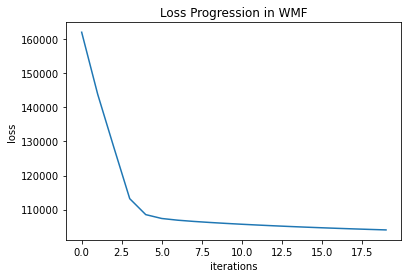

In [21]:
als_model.plotLoss()

It looks like the loss has almost converged, even though some more training might be beneficial. At this point, we have obtained an embedding for the users $U$ and one for the items $V$. We will use them both to avoid to store the whole matrix $C$ and to be able to make quick recommendations to a specific user.

In [26]:
# The following are the embeddings. We don't show them explicitly just because the matrixes
# are a bit too big to show here.

# embedding for users U:       als_model.U
# embedding for artists V:     als_model.V

### 2.4. Explanative power of weights

The following table gives an idea about the interpretation we can give to the weights of the model.

In [27]:
user_to_explain = 0
item_to_explain = 10

# the higher the confidence weight and the user-perceived item similarity,
# the more influence that item has on "item_to_explain"
als_model.explain(user_to_explain, item_to_explain)

Predicted Score for User u on Item i: 0.7528226076730284
Item No. | User-Perceived Item Simialrity | Confidence Weight | C
       1 |                        0.00203 |               1.0 | 0.0
       2 |                       -0.00034 |              41.0 | 1.0
       3 |                        0.00503 |              41.0 | 1.0
       4 |                        0.00135 |              41.0 | 1.0
       5 |                         -0.001 |              41.0 | 1.0
       6 |                         0.0027 |              41.0 | 1.0
       7 |                        0.00472 |              41.0 | 1.0
       8 |                        0.00045 |              41.0 | 1.0
       9 |                       -0.00039 |              41.0 | 1.0
      10 |                        0.00079 |              41.0 | 1.0
      11 |                        0.00505 |              41.0 | 1.0
      12 |                         -6e-05 |               1.0 | 0.0
      13 |                        0.00427 |               1.0

## 3. Input a user

- Choose a user by specifying the row of the matrix that represents the documents liked by that user. The first user is 0.
- You can also choose the number of documents the user should be recommended (default=10)

In [28]:
# here you can select the user
selected_user = 0

# here you can select the number of documents to be recommended
selected_docs = 10

In [29]:
num_users = C.shape[0]
num_users

if selected_user >= 0 and selected_user < num_users:
    print('Accepted user ! We will soon be recommending documents which are relevant to him!')
else:
    raise ValueError(f'selected user should be a value between 0 and {num_users-1}')

Accepted user ! We will soon be recommending documents which are relevant to him!


## 4. Ranking documents for the selected user

### 4.1 Ranking algorithm

This algorithm consists in using the embeddings produced by the Weighted Matrix Factorization function previously implemented. 

$C_{WMF} = U \cdot V^T$ gives an approximation of $C$.

Moreover, each row of $C_{WMF}$ gives a scoring of the documents (at least documents which are not absolutely new, but have been evaluated at least once by some user) for the user that the row represents.
We do not need to store the whole matrix $C_{WMF}$ in memory, we can just pre-process the embeddings $U$ and $V$ and produce a recommendation for a specific user without computing the whole matrix. To get a user prediction we multiply the row corresponding to the user preferences in U by the whole matrix V.

In [53]:
# get a prediction in the form of a vector of scores for the selected_user
rowU = als_model.U[selected_user].reshape(1, -1)
prediction_Selected_User = als_model.U[selected_user].dot(als_model.V.T)

# add the score column
df_artists['score'] = prediction_Selected_User

# get a ranking of top recommended documents to the selected_user
idx_sorted = np.argsort(prediction_Selected_User)[::-1]

# sort the entire dataframe according to the index
df_artists = df_artists.set_index('id')
df_artists = df_artists.reindex(idx_sorted)

# drop column related to artistID because we now have 
# the names which are visually more intuitive
df_artists = df_artists.reset_index().drop(columns=['id'])

# add the column representing each artist ranking order (in the recommendation)
df_artists['top_ranked'] = range(1, df_artists.shape[0]+1)
df_artists = df_artists.rename(columns={'name':'artistName'})


In [54]:
# showing the pre-chosen number top-ranked artists
df_artists[:selected_docs]

,artistName,score,top_ranked
0,Björk,1.081192,1
1,Crystal Castles,1.024871,2
2,Portishead,0.978717,3
3,Depeche Mode,0.966771,4
4,Massive Attack,0.965267,5
5,Yeah Yeah Yeahs,0.961637,6
6,Arcade Fire,0.941990,7
7,Sigur Rós,0.934773,8
8,MGMT,0.933087,9
9,Keane,0.932221,10


- cold start for user: among all the recommended artists, we might recommend for a half the freshest/newest and for the second half the best rated artists among all users.
- cold start for item: recommend based on "genre" or some feature/tag which might be present already when the item is being introduced. A component of fresh items might be recommended as well to each user (e.g. 10% of his feed). 

Here, we don't have any artist/user feature or timestamp for new users/items. Moreover, this phase is highly specific and dependent on the type of recommendations and information available.

# Possible better and innovative model

New approach: **LightGCN** (within the **family of GNNs**)
    
- graph-based approach exploiting graph machine learning
- light in terms of weights to store (it computes a sort of embedding for items and users)
- it better exploits the bipartite structure by making good use of the graph, instead of using a tabular dataset. The model performs better than standard WMF: while WMF can be considered as a first order approximation of the original dataset, LightGCN also "aggregates" and "weights" information coming from broader node neighbourhoods. Therefore, the predictions tend to better capture the similarity about users and items as well.